# [vis] real ble data (stationary d=1cm,10cm)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import IPython
import IPython.display

In [2]:
CSV_FILE_PATH_COM7 = "../data/real_ble_data_COM7.csv"
CSV_FILE_PATH_COM9 = "../data/real_ble_data_COM9.csv"

### Load CSV as dataframe

In [3]:
df_com7 = pd.read_csv(CSV_FILE_PATH_COM7)
df_com9 = pd.read_csv(CSV_FILE_PATH_COM9)

In [4]:
df_com7.head()

,address,packet_id,rssi,count,rx_speed,tx_speed,last_time_elapsed,total_time_elapsed,timestamp
0,f0:91:27:6b:7a:0a,1,-29,1,80.00,80.00,202534,80,202534
1,f0:91:27:6b:7a:0a,2,-31,2,82.00,82.00,84,164,202618
2,f0:91:27:6b:7a:0a,4,-29,3,107.33,80.50,158,322,202776
3,f0:91:27:6b:7a:0a,10,-29,4,201.50,80.60,484,806,203260
4,f0:91:27:6b:7a:0a,11,-30,5,176.80,80.36,78,884,203338


### Plot Raw Data over Time

In [5]:
def plot_over_time(df):
    df_sample = df
    plt.figure(figsize=(25,8))
    plt.subplot(211)
    plt.plot(df_sample['timestamp'], df_sample['rssi'], linestyle='-')
    plt.xlabel('timestamp (ms)')
    plt.ylabel('rssi (dBm)')
    plt.subplot(212)
    plt.scatter(df_sample['timestamp'], df_sample['rssi'], s=2)
    plt.xlabel('timestamp (ms)')
    plt.ylabel('rssi (dBm)')
    plt.show()

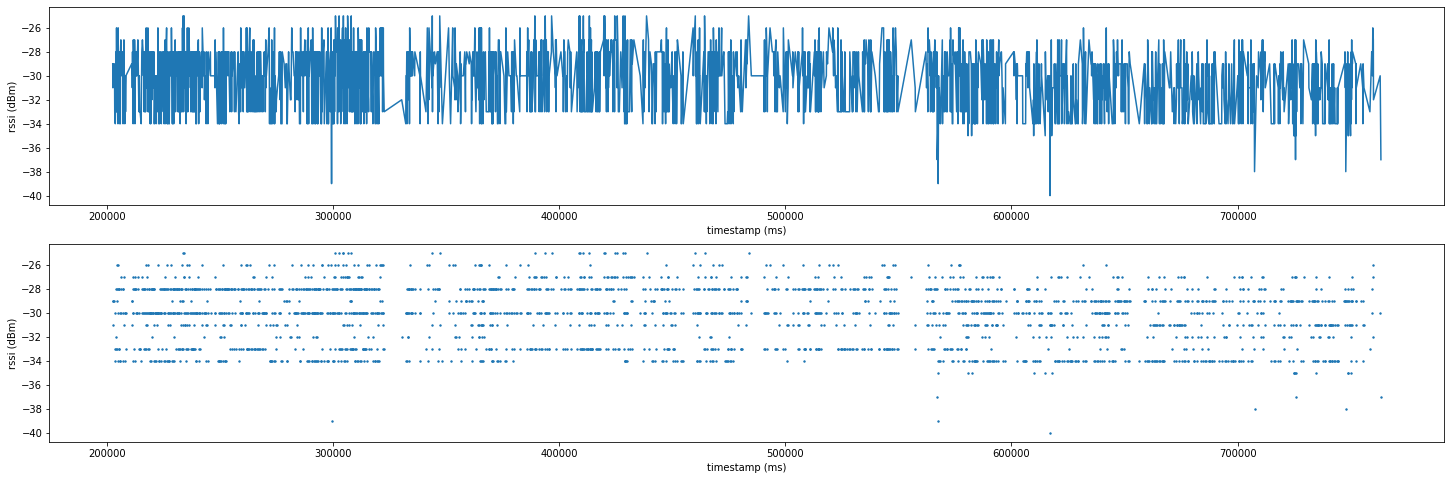

In [6]:
plot_over_time(df_com7)

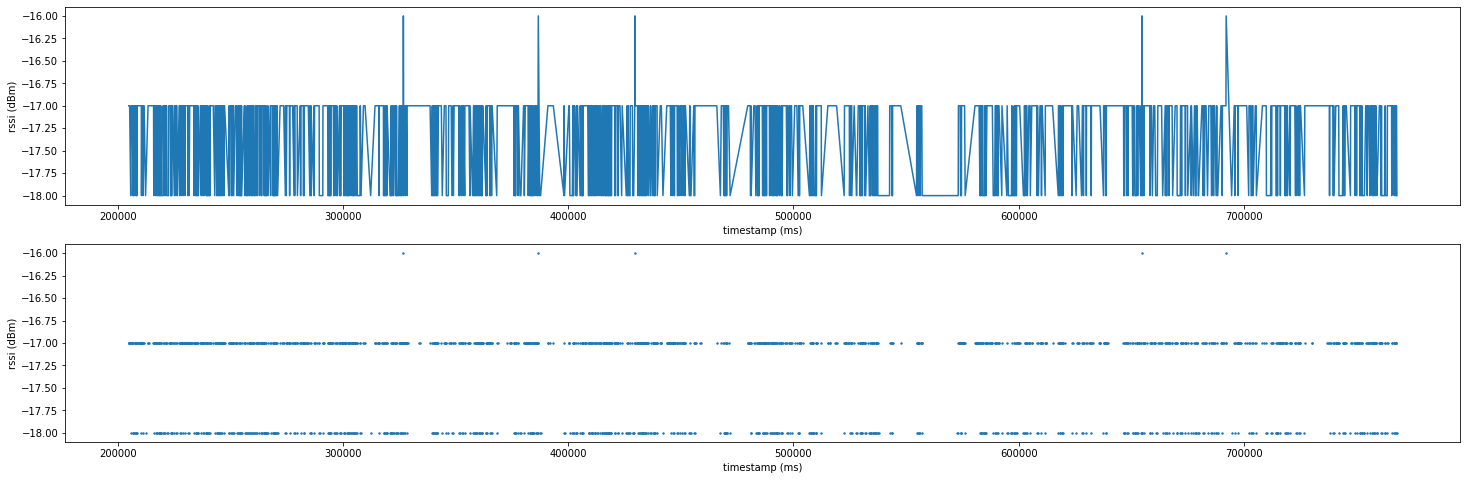

In [7]:
plot_over_time(df_com9)

### Plot Distribution Data over Time

To estimate the distribution with in a small sampling period, we move a time window across the dataset.

In [8]:
SAMPLE_WINDOW = 1000
MAX_RSSI = 0
MIN_RSSI = -99

##### Calculate Distribution Over Time

In [9]:
def to_sparse(inp):
    out = np.zeros(MAX_RSSI - MIN_RSSI + 1)
    for key in inp.keys():
        if key > 0:
            out[0] += inp[key]
        elif key < -99:
            out[99] += inp[key]
        else:
            index = np.abs(key)
            out[index] += inp[key]
    return out

def calc_pdf_seq(df):
    df_sample = df
    pdf_seq = []

    

    for index in range(len(df_sample)):
        pdf = {}
        start_time = df_sample.iloc[index].timestamp

        rssis = df_sample[(df_sample.timestamp < start_time + SAMPLE_WINDOW) & (df_sample.timestamp >= start_time)].rssi.to_numpy()
        for rssi in rssis:
            if rssi in pdf:
                pdf[rssi] += 1
            else:
                pdf[rssi] = 1
        pdf_seq.append(to_sparse(pdf))
    return np.array(pdf_seq)

In [10]:
def plot_pdf_seq(pdf_seq):
    plt.figure(figsize=(25,6))
    ax = sns.heatmap(pdf_seq.transpose(1,0),cmap="viridis")
    plt.xlabel('timestamp (ms)')
    plt.ylabel('rssi (dBm)')
    plt.show()

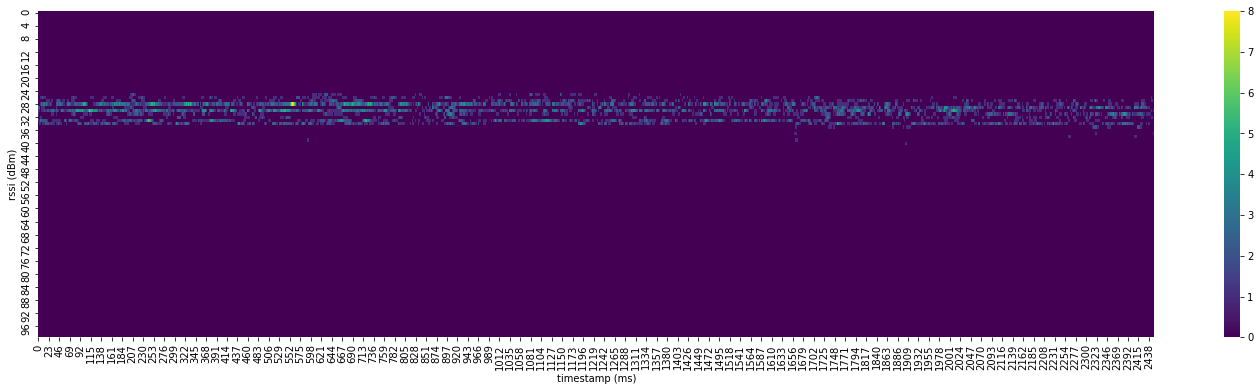

In [11]:
pdf_seq_com7 = calc_pdf_seq(df_com7)
plot_pdf_seq(pdf_seq_com7)

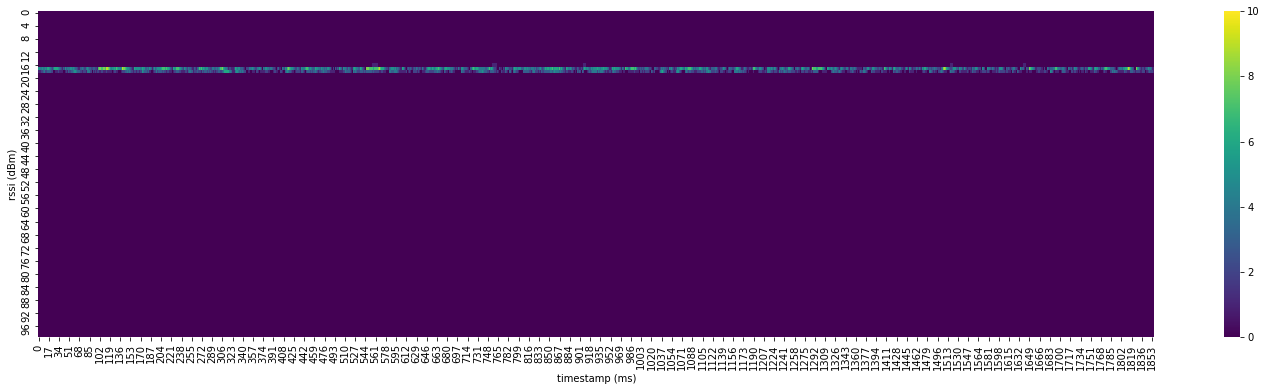

In [12]:
pdf_seq_com9 = calc_pdf_seq(df_com9)
plot_pdf_seq(pdf_seq_com9)

In [13]:
def plot_pdf(pdf):
    fig, ax = plt.subplots(figsize=(25,6))
    x_labels = np.arange(MAX_RSSI, MIN_RSSI-1, -1)
    plt.bar(x_labels, pdf)
    plt.xlabel('rssi (dBm)')
    plt.ylabel('count')
    plt.xticks(np.arange(MAX_RSSI, MIN_RSSI-1, step=-2))
    ax.invert_xaxis()
    plt.show()
    
def plot_pdf_anim(pdf_seq, n=10):
    for i in range(n):
        if i >= len(pdf_seq):
            break
        plot_pdf(pdf_seq[i])
        print(f"Frame {i}")
        IPython.display.clear_output(wait = True)

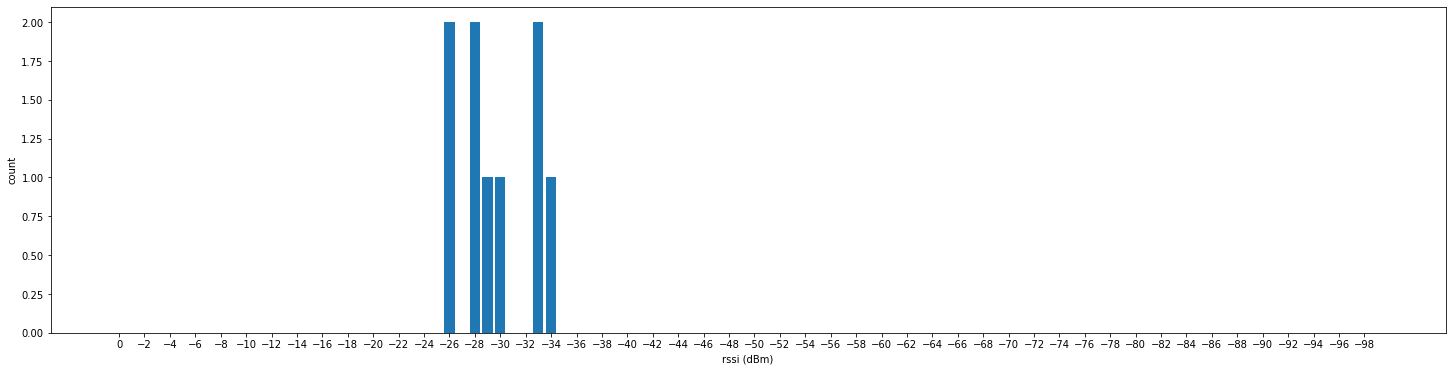

Frame 9


In [14]:
plot_pdf_anim(pdf_seq_com7)

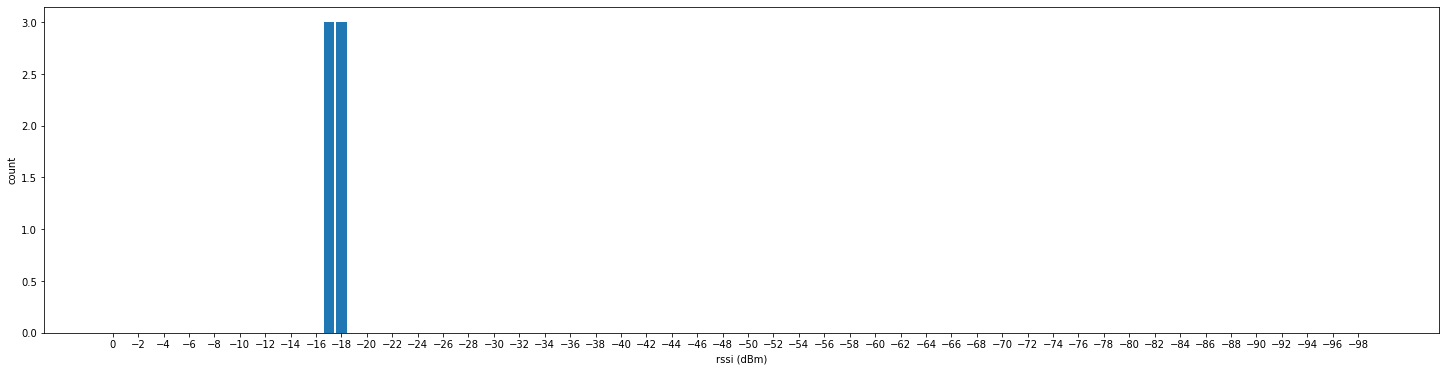

Frame 9


In [15]:
plot_pdf_anim(pdf_seq_com9)

##### Observation

The probability distribution on different path seems has similar weight? why?

### Speed

In [16]:
def plot_time_cost_per_packet(df1, df2,legend):
    plt.figure(figsize=(25,5))
    plt.scatter(df1['packet_id'], df1['rx_speed'], marker='o', c='g', s=2)
    plt.scatter(df1['packet_id'], df1['tx_speed'], marker='.', c='g', s=2)
    plt.scatter(df2['packet_id'], df2['rx_speed'], marker='x', c='r', s=2)
    plt.scatter(df2['packet_id'], df2['tx_speed'], marker='.', c='r', s=2)
    plt.xlabel('timestamp (ms)')
    plt.ylabel('speed (ms/p)')
    plt.legend([legend[0]+' rx',legend[0]+' tx',legend[1]+' rx',legend[1]+' tx'])
    plt.show()

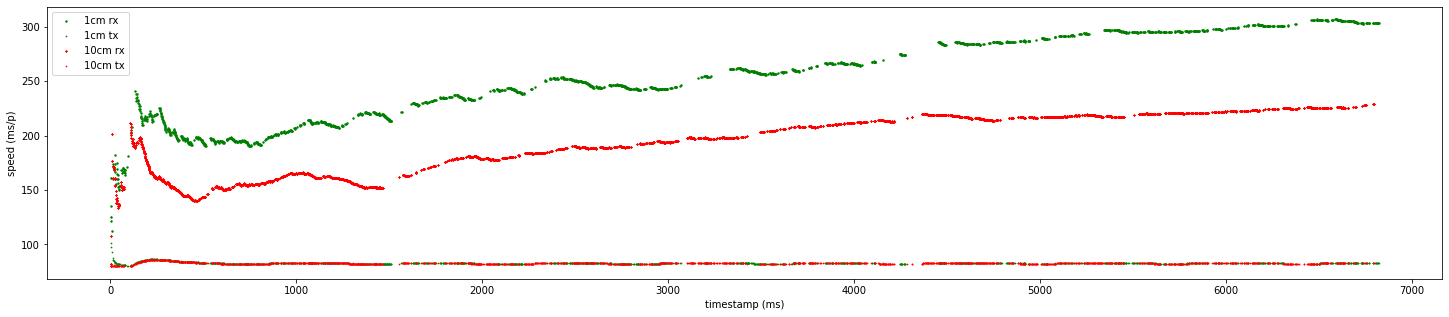

In [20]:
plot_time_cost_per_packet(df_com9, df_com7, legend=['1cm','10cm'])

### Packet Loss Rate

In [23]:
def plot_packet_loss_rate(df1, df2, legend):
    plt.figure(figsize=(25,5))
    plt.scatter(df1['packet_id'], 1 - df1['tx_speed'] / df1['rx_speed'], marker='o', c='g', s=2)
    plt.scatter(df2['packet_id'], 1 - df2['tx_speed'] / df2['rx_speed'], marker='x', c='r', s=2)
    plt.xlabel('timestamp (ms)')
    plt.ylabel('loss')
    plt.legend(legend)
    plt.show()

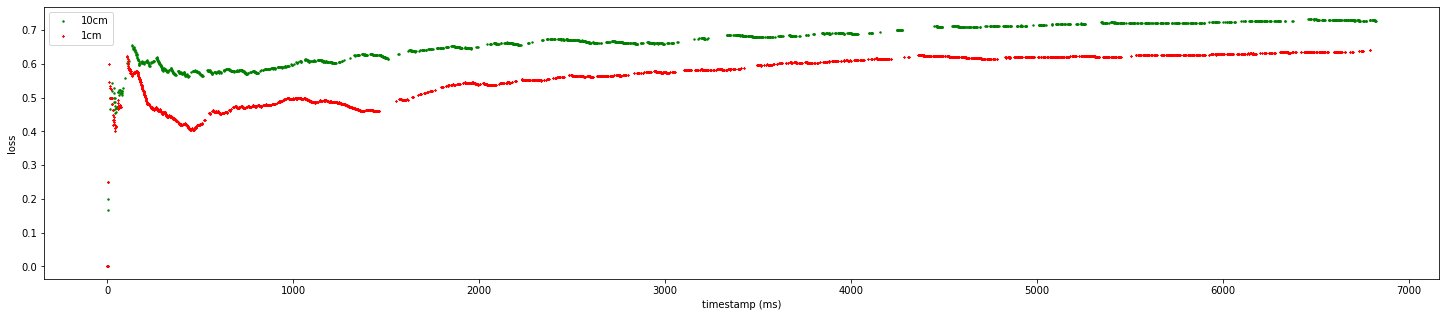

In [24]:
plot_packet_loss_rate(df_com9, df_com7, legend=['10cm','1cm'])